In [1]:
import pandas as pd
import numpy as np

# Read csv
listings_df = pd.read_csv('./data/with_amenities_and_estimated_income.csv', low_memory = False)

# Drop columns that aren't related to income or not feasible to capture from user
columns_to_drop = ['Unnamed: 0', 'id', 'scrape_id', 'host_id', 'host_total_listings_count',
                  'latitude', 'longitude', 'availability_30', 'availability_60', 'availability_90',
                  'availability_365', 'number_of_reviews', 'calculated_host_listings_count', 
                  'reviews_per_month', 'Other', 'listing_url', 'last_scraped', 'host_name',
                  'experiences_offered', 'picture_url', 'name', 'host_url', 'host_since',
                  'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_listings_count',
                  'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street',
                  'city', 'neighbourhood_group_cleansed', 'smart_location', 'country_code',
                  'country', 'is_location_exact', 'amenities', 'price', 'calendar_updated', 'has_availability',
                  'calendar_last_scraped', 'first_review', 'last_review', 'requires_license',
                  'jurisdiction_names', 'instant_bookable', 'is_business_travel_ready',
                  'cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification',
                  'translation missing: en.hosting_amenity_49', 'summary', 'space', 'description',
                  'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules',
                  'thumbnail_url', 'medium_url', 'xl_picture_url', 'host_location', 'host_about',
                  'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'state',
                  'neighbourhood_cleansed', 'host_neighbourhood', 'license', 'review_scores_rating',
                  'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                  'review_scores_communication', 'review_scores_location', 'review_scores_value',
                  'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'market']
for col in columns_to_drop:
    listings_df.drop([col], axis=1, inplace=True)

# Remove rows that don't have an estimated income per month
listings_df = listings_df[~pd.isna(listings_df['estimated_income_per_month'])]

# Dropping square feet because 7450 out of 7712 (97%) rows are null
listings_df.drop(['square_feet'], axis=1, inplace=True)

# Fill values going forward
listings_df.fillna(method ='ffill', inplace=True)

# Convert zipcode to string rather than float
listings_df['zipcode'] = listings_df['zipcode'].astype('int').astype('str')

# Convert $ amount for extra people from string to float
listings_df['extra_people'] = listings_df['extra_people'].apply(lambda s: s[1:]).astype('float')

set(listings_df['property_type'])

{'Aparthotel',
 'Apartment',
 'Bed and breakfast',
 'Boat',
 'Boutique hotel',
 'Bungalow',
 'Cabin',
 'Camper/RV',
 'Castle',
 'Condominium',
 'Cottage',
 'Earth house',
 'Farm stay',
 'Guest suite',
 'Guesthouse',
 'Hostel',
 'House',
 'Houseboat',
 'Hut',
 'In-law',
 'Lighthouse',
 'Loft',
 'Other',
 'Serviced apartment',
 'Tent',
 'Tiny house',
 'Townhouse',
 'Treehouse',
 'Villa',
 'Yurt'}

In [2]:
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold, SelectPercentile, RFE
from sklearn.linear_model import LinearRegression

amenities = listings_df.iloc[:, 13:-1]
y = np.ravel(listings_df.iloc[:, [-1]])

# Select 20 top amenities
select = RFE(LinearRegression(), 20).fit(amenities, y)
cols_rfe = [col for i, col in enumerate(amenities.columns.values) if select.get_support()[i]]
print(cols_rfe)

# Remove amenities that weren't selected
remove_cols = [col for i, col in enumerate(amenities.columns.values) if not select.get_support()[i]]
for col in remove_cols:
    listings_df.drop([col], axis=1, inplace=True)

['Heat lamps', 'Sound system', 'Shared gym', 'Pack ’n Play/travel crib', 'Balcony', 'Waterfront', 'Fire pit', 'Wine cooler', 'Shared hot tub', 'Doorman', 'Printer', 'Shared pool', 'Ski-in/Ski-out', 'Private gym', 'Heated towel rack', 'Mountain view', 'Formal dining area', 'Bidet', 'Standing valet', 'Sun loungers']


In [3]:
listings_df = pd.get_dummies(listings_df)
listings_df
estimated_income = listings_df['estimated_income_per_month']
listings_df = listings_df.drop(['estimated_income_per_month'], axis=1)


In [4]:
from sklearn.model_selection import train_test_split # splitting data

train_features, test_features, train_outcome, test_outcome = train_test_split(
    listings_df,
    estimated_income,
    test_size=0.20, 
    random_state=11
)

In [5]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler       # scaling data
from sklearn.model_selection import GridSearchCV     # for grid search
from sklearn.pipeline import Pipeline                # for making pipelines
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold

scaler = MinMaxScaler()

# define a pipeline
pipe = Pipeline([('scaler', scaler), ('KNeighborsRegressor', KNeighborsRegressor())])

folds = KFold(n_splits = 3, shuffle = True)

# defines a grid to search through
param_grid = {
    'KNeighborsRegressor__n_neighbors': range(51, 102, 50),
    'KNeighborsRegressor__weights': ["distance"]
}

# performs a grid search of pipeline
knn_grid = GridSearchCV(pipe, param_grid, cv=folds, scoring="neg_mean_absolute_error", verbose=3)
knn_model = knn_grid.fit(train_features, train_outcome)

print('Training MAE:', knn_model.best_score_)
print('Testing MAE:', knn_model.score(test_features, test_outcome))
print(knn_model.best_estimator_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] KNeighborsRegressor__n_neighbors=51, KNeighborsRegressor__weights=distance 
[CV]  KNeighborsRegressor__n_neighbors=51, KNeighborsRegressor__weights=distance, score=-1058.7524187829076, total=   2.2s
[CV] KNeighborsRegressor__n_neighbors=51, KNeighborsRegressor__weights=distance 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s


[CV]  KNeighborsRegressor__n_neighbors=51, KNeighborsRegressor__weights=distance, score=-1041.1381547200667, total=   2.3s
[CV] KNeighborsRegressor__n_neighbors=51, KNeighborsRegressor__weights=distance 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.3s remaining:    0.0s


[CV]  KNeighborsRegressor__n_neighbors=51, KNeighborsRegressor__weights=distance, score=-1015.7386701408502, total=   2.2s
[CV] KNeighborsRegressor__n_neighbors=101, KNeighborsRegressor__weights=distance 
[CV]  KNeighborsRegressor__n_neighbors=101, KNeighborsRegressor__weights=distance, score=-1056.3067265700397, total=   2.2s
[CV] KNeighborsRegressor__n_neighbors=101, KNeighborsRegressor__weights=distance 
[CV]  KNeighborsRegressor__n_neighbors=101, KNeighborsRegressor__weights=distance, score=-1040.8555393274714, total=   2.1s
[CV] KNeighborsRegressor__n_neighbors=101, KNeighborsRegressor__weights=distance 
[CV]  KNeighborsRegressor__n_neighbors=101, KNeighborsRegressor__weights=distance, score=-1015.2211624546759, total=   2.1s
Training MAE: -1037.464197668774


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   40.4s finished


Testing MAE: -1060.8400526414678
Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('KNeighborsRegressor', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=101, p=2,
          weights='distance'))])


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler       # scaling data
from sklearn.model_selection import GridSearchCV     # for grid search
from sklearn.pipeline import Pipeline                # for making pipelines
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold

scaler = MinMaxScaler()

# define a pipeline
pipe = Pipeline([('scaler', scaler), ('LogisticRegression', LogisticRegression())])

folds = KFold(n_splits = 3, shuffle = True)

# defines a grid to search through
param_grid = {
    'LogisticRegression__penalty': ['l2']
}

# performs a grid search of pipeline
log_grid = GridSearchCV(pipe, param_grid, cv=folds, scoring="neg_mean_absolute_error", verbose=3)
log_model = log_grid.fit(train_features, train_outcome)

print('Training MAE:', log_model.best_score_)
print('Testing MAE:', log_model.score(test_features, test_outcome))
print(log_model.best_estimator_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] LogisticRegression__penalty=l2 ..................................
[CV]  LogisticRegression__penalty=l2, score=-1211.476421973748, total=  10.2s
[CV] LogisticRegression__penalty=l2 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.3s remaining:    0.0s


[CV]  LogisticRegression__penalty=l2, score=-1149.532587548638, total=   9.8s
[CV] LogisticRegression__penalty=l2 ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   20.1s remaining:    0.0s


[CV]  LogisticRegression__penalty=l2, score=-1207.7344357976654, total=   9.9s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   30.1s finished


Training MAE: -1189.5846976819582
Testing MAE: -1226.8139987038237
Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('LogisticRegression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])


In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler       # scaling data
from sklearn.model_selection import GridSearchCV     # for grid search
from sklearn.pipeline import Pipeline                # for making pipelines
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold

scaler = MinMaxScaler()

# define a pipeline
pipe = Pipeline([('scaler', scaler), ('RandomForestRegressor', RandomForestRegressor())])

folds = KFold(n_splits = 3, shuffle = True)

# defines a grid to search through
param_grid = {
    'RandomForestRegressor__n_estimators': [1000]
}

# performs a grid search of pipeline
rand_forest_grid = GridSearchCV(pipe, param_grid, cv=folds, scoring="neg_mean_absolute_error", verbose=3)
rand_forest_model = rand_forest_grid.fit(train_features, train_outcome)

print('Training MAE:', rand_forest_model.best_score_)
print('Testing MAE:', rand_forest_model.score(test_features, test_outcome))
print(rand_forest_model.best_estimator_)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] RandomForestRegressor__n_estimators=1000 ........................
[CV]  RandomForestRegressor__n_estimators=1000, score=-968.9111323599225, total=  32.0s
[CV] RandomForestRegressor__n_estimators=1000 ........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.7s remaining:    0.0s


[CV]  RandomForestRegressor__n_estimators=1000, score=-961.500219573602, total=  31.5s
[CV] RandomForestRegressor__n_estimators=1000 ........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV]  RandomForestRegressor__n_estimators=1000, score=-972.9620598683364, total=  31.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.6min finished


Training MAE: -967.7913188194175
Testing MAE: -994.3763671394732
Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('RandomForestRegressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])


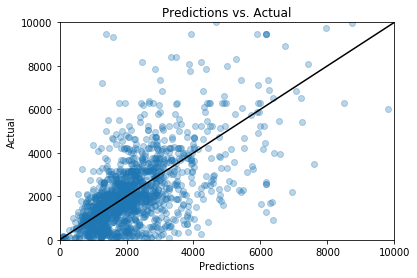

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

test_outcome
test_preds = rand_forest_model.predict(test_features)

plt.scatter(test_preds, test_outcome, alpha=.3)
plt.plot([0, 10000], [0, 10000], color='black')
plt.ylim(bottom=0, top=10000)
plt.xlim(left=0, right=10000)
plt.title('Predictions vs. Actual')
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.show()

In [8]:
test_features[:15]

,accommodates,bathrooms,bedrooms,beds,guests_included,extra_people,minimum_nights,maximum_nights,Heat lamps,Sound system,...,property_type_Villa,property_type_Yurt,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed
5592,2,1.0,1.0,1.0,2,40.0,4,1125,0,0,...,0,0,1,0,0,0,0,0,0,1
3967,4,2.0,2.0,2.0,4,50.0,3,1125,0,0,...,0,0,1,0,0,0,0,0,0,1
2913,4,1.0,0.0,3.0,2,20.0,1,27,0,0,...,0,0,1,0,0,0,0,0,0,1
6564,2,1.0,1.0,1.0,1,0.0,2,1125,0,0,...,0,0,0,1,0,0,0,0,0,1
243,6,2.0,2.0,0.0,1,0.0,2,365,0,0,...,0,0,1,0,0,0,0,0,0,1
4480,3,1.0,0.0,1.0,2,30.0,21,1125,0,0,...,0,0,1,0,0,0,0,0,0,1
7333,4,1.0,1.0,1.0,2,15.0,1,31,0,0,...,0,0,1,0,0,0,0,0,0,1
7329,6,2.0,4.0,7.0,1,0.0,7,14,0,0,...,0,0,1,0,0,0,0,0,0,1
5110,1,2.0,1.0,1.0,1,0.0,1,120,0,0,...,0,0,0,1,0,0,0,0,0,1
5042,2,1.5,1.0,1.0,2,10.0,2,45,0,0,...,0,0,0,1,0,0,0,0,0,1


In [9]:
print('Actual    :', list(test_outcome[:15].astype('int')))
print('Predicted :', list(rand_forest_model.predict(test_features[:15]).astype('int')))

Actual    : [1355, 1850, 3339, 1640, 2101, 3339, 2520, 1051, 798, 394, 2079, 11025, 3675, 630, 1067]
Predicted : [2284, 2832, 2374, 1020, 3682, 3434, 2055, 959, 896, 1170, 1376, 9637, 3956, 654, 1313]
